# Product Recognition on Store Shelves

- Baraghini Nicholas
- Marini Luca

### Import of the libraries

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

## Step A - Multiple Product Detection:

Load first scene image

In [2]:
#Load Scene
scene_img = cv2.imread('./scenes/e1.png', cv2.COLOR_BGR2RGB)

#Plot Scene
plt.figure(figsize=(20, 10)) 
plt.imshow(cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGB));

Load first model image

In [3]:
#Load Model
model_img = cv2.imread('./models/0.jpg', cv2.COLOR_BGR2RGB)

#Plot Model
plt.figure() 
plt.imshow(cv2.cvtColor(model_img, cv2.COLOR_BGR2RGB));

In [4]:
sift = cv2.xfeatures2d.SIFT_create()

In [5]:
# model_img = cv2.cvtColor(model_img, cv2.COLOR_BGR2GRAY)
kp_model = sift.detect(model_img)

In [6]:
# Number of keypoints 
print(len(kp_model))

# Location of the keypoint
print(kp_model[0].pt)

# Scale
print(kp_model[0].size)

# Rotation
print(kp_model[0].angle)

8044
(3.1264805793762207, 817.734375)
3.059957265853882
175.85983276367188


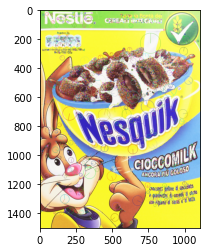

In [7]:
model_img_visualization = cv2.drawKeypoints(model_img, kp_model, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(cv2.cvtColor(model_img_visualization, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
# scene_img = cv2.cvtColor(scene_img, cv2.COLOR_BGR2GRAY)
kp_scene = sift.detect(scene_img)

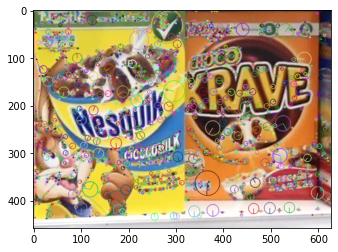

In [9]:
scene_img_visualization = cv2.drawKeypoints(scene_img,kp_scene,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(cv2.cvtColor(scene_img_visualization, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
#Plot Scene
#plt.figure(figsize=(20, 10)) 
#plt.imshow(cv2.cvtColor(scene,cv2.COLOR_BGR2RGB))

In [11]:
kp_model, des_model = sift.compute(model_img, kp_model)
kp_scene, des_scene = sift.compute(scene_img, kp_scene)

In [12]:
print("Number of model descriptors: ", len(des_model))
print("Dimensionality of a SIFT descriptor: ", des_model[0].shape)
print("Type of the descriptor: ", des_model[0].dtype)

Number of model descriptors:  8044
Dimensionality of a SIFT descriptor:  (128,)
Type of the descriptor:  float32


Defining a function which find matches between keypoints belonging to the model, with keypoints belonging to the scene, and through a threshold collects all the worth considered matches in a list, which is then returned by the function itself

In [13]:
def Matching(Model_Descriptors, Scene_Descriptors, Treshold = 0.45, k=2):
    FLANN_INDEX_KDTREE = 1

        # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

        # Defining search params.
        # checks=50 specifies the number of times the trees in the index should be recursively traversed.
        # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

        # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
        # Matching and finding the 2 closest elements for each query descriptor.
    matches = flann.knnMatch(Model_Descriptors, Scene_Descriptors, k)
        #defining an array containing all the matches that results to be considered "good" matches applying a certain treshold 
    good = []
    for m,n in matches:
        if m.distance < Treshold * n.distance: #  if m.distance/n.distance < Threshold:
            good.append(m)
            
    return good

In [14]:
good = Matching(des_model, des_scene)

In [15]:
# Checking if we found enough matching
MIN_MATCH_COUNT = 30
print(len(good))
if len(good)>MIN_MATCH_COUNT:
    
    # building the corrspondences arrays of good matches
    src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    # Using RANSAC to estimate a robust homography. 
    # It returns the homography M and a mask for the discarded points
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Mask of discarded point used in visualization
    matchesMask = mask.ravel().tolist()
    
    # Corners of the query image
    h,w = model_img.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2) # myc: these are the 4 corners of the query image
    
    # Projecting the corners into the train image
    dst = cv2.perspectiveTransform(pts,M) # myc: you project the corners by using the homography. M is the homography

    # Drawing the bounding box
    scene_img = cv2.polylines(scene_img, [np.int32(dst)],True, (0, 255, 0), 3, cv2.LINE_AA)
    
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

149


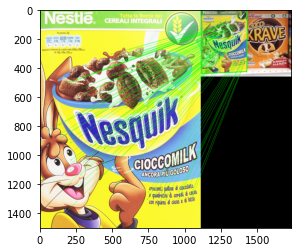

In [16]:
# Drawing the matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None, # not draw keypoints only matching lines
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2) # not draw keypoints only lines
img3 = cv2.drawMatches(model_img, kp_model, scene_img, kp_scene, good, None, **draw_params)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.show()

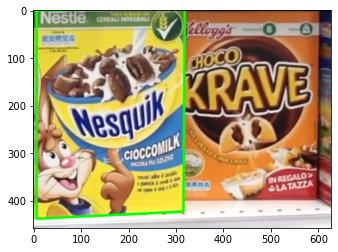

In [17]:
plt.imshow(cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGB))
plt.show()

Creation of some dictionaries that contain all the keypoint, descriptors and images that we will need during stepA, so that they are loaded once and at the beginning, to save later computational cost.

In [19]:
NUM_OF_MODELS = 27

# Dictionary that contains the image, all keypoints and descriptors for each model images
model_images_features = {}

for i in range(NUM_OF_MODELS):
    model_img = cv2.imread('./models/{}.jpg'.format(i), cv2.COLOR_BGR2RGB)
    kp_model = sift.detect(model_img)
    kp_model, des_model = sift.compute(model_img, kp_model)
    model_images_features[i] = [model_img, kp_model, des_model]
    # plt.imshow(cv2.cvtColor(model_images_features[str(i)][0], cv2.COLOR_BGR2RGB))
    # plt.show()

In [20]:
scenes_to_test = [1, 2, 3, 4, 5]

# Dictionary that contains the image, all keypoints and descriptors for each easy scene image
e_scenes_images_features = {}

for i in scenes_to_test:
    scene_img = cv2.imread('./scenes/e{}.png'.format(i), cv2.COLOR_BGR2RGB)
    kp_scene = sift.detect(scene_img)
    kp_scene, des_scene = sift.compute(scene_img, kp_scene)
    e_scenes_images_features[i] = [scene_img, kp_scene, des_scene]
    # scene_img_visualization = cv2.drawKeypoints(scene_img,kp_e_scemes_images['1'],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # plt.imshow(cv2.cvtColor(e_scenes_images_features[str(i)][0], cv2.COLOR_BGR2RGB))
    # plt.show()

Function that will output the position in the image reference system of each instance 

In [21]:
def print_result(e_results, idx_of_scene):
    for i in models_to_test:
        print('Product {} - {} instance/s found:'.format(i, e_results[idx_of_scene][i]['count']))
        if e_results[idx_of_scene][i].get('width', None):
            print('\tInstance  position: {}, width: {}px, height: {}px'.format(e_results[idx_of_scene][i]['pos'], e_results[idx_of_scene][i]['width'], e_results[idx_of_scene][i]['height']))

In [22]:
# dictionary that will contain the output to be printed
e_results = {}    

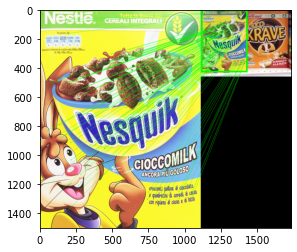

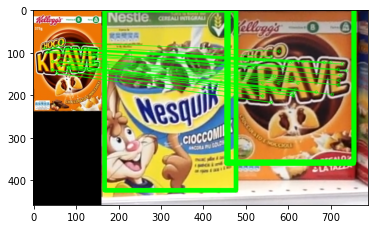

Not enough matches are found - 0/20


Not enough matches are found - 1/20


Not enough matches are found - 19/20


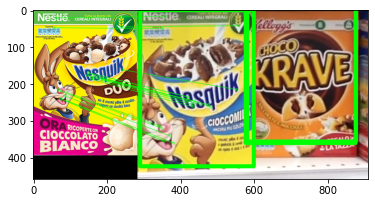

Not enough matches are found - 2/20


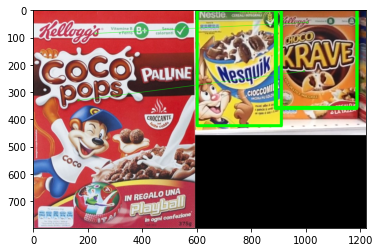

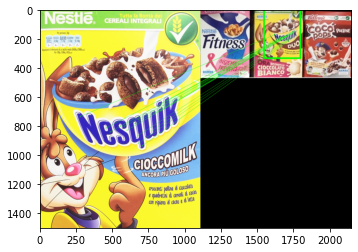

Not enough matches are found - 10/20


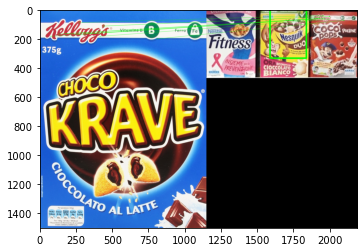

Not enough matches are found - 0/20


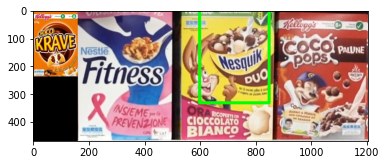

Not enough matches are found - 0/20


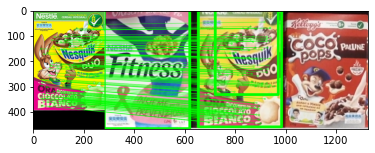

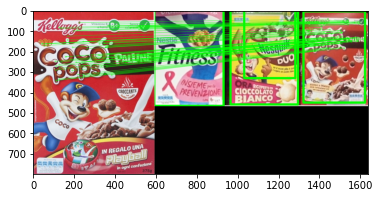

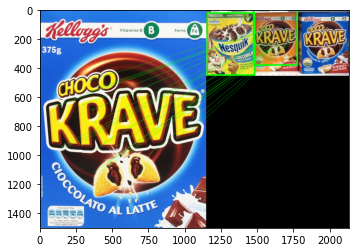

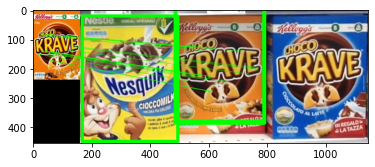

Not enough matches are found - 0/20


Not enough matches are found - 0/20


Not enough matches are found - 16/20


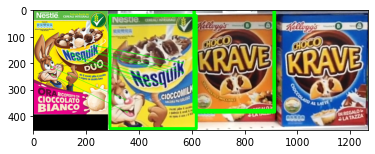

Not enough matches are found - 14/20


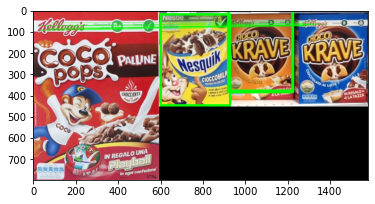

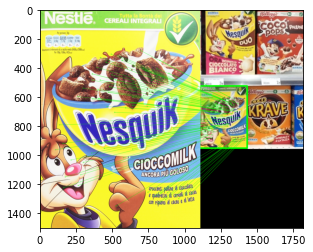

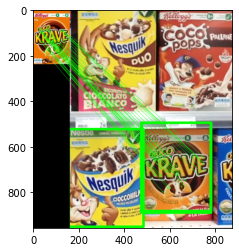

Not enough matches are found - 0/20


Not enough matches are found - 0/20


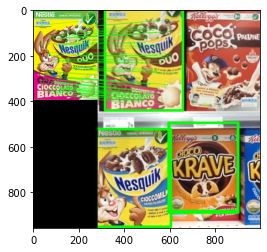

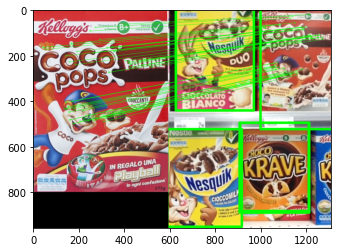

Not enough matches are found - 0/20


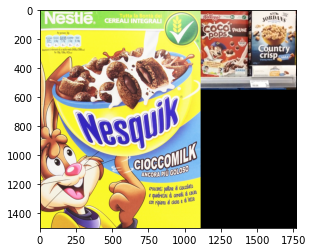

Not enough matches are found - 7/20


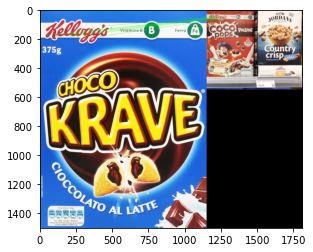

Not enough matches are found - 0/20


Not enough matches are found - 0/20


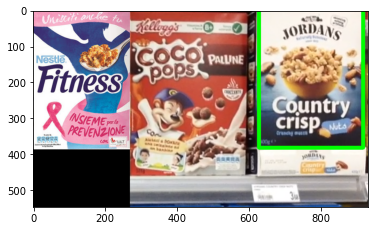

Not enough matches are found - 0/20


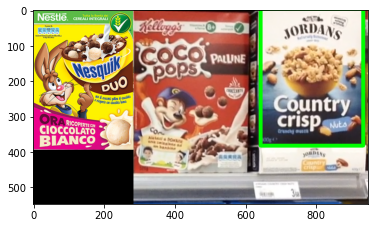

In [23]:
IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2

models_to_test = [0, 1, 11, 19, 24, 26, 25]

for j in scenes_to_test:
    e_results[j] = {}
    for i in models_to_test:
        
        e_results[j][i] = {}
        e_results[j][i]['count'] = 0
        
        good = Matching(model_images_features[i][DESCRIPTOR_INDEX], e_scenes_images_features[j][DESCRIPTOR_INDEX], Treshold = 0.45, k=2)#flann.knnMatch(model_images_features[i][DESCRIPTOR_INDEX], e_scenes_images_features[j][DESCRIPTOR_INDEX], k=2)
        # Checking if we found enough matching
        MIN_MATCH_COUNT = 20
        
        # If enough matches => the model is in the scene image
        if len(good) > MIN_MATCH_COUNT:
            
            
            e_results[j][i]['count'] += 1
            # building the corrspondences arrays of good matches
            src_pts = np.float32([ model_images_features[i][KEYPOINT_INDEX][m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ e_scenes_images_features[j][KEYPOINT_INDEX][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            
            # Using RANSAC to estimate a robust homography. 
            # It returns the homography M and a mask for the discarded points
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Mask of discarded point used in visualization
            matchesMask = mask.ravel().tolist()

            # Corners of the query image
            h,w = model_images_features[i][IMAGE_INDEX].shape[:2]
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2) # myc: these are the 4 corners of the query image
            
            # Projecting the corners into the train image
            dst = cv2.perspectiveTransform(pts,M) # myc: you project the corners by using the homography. M is the homography          
            
            # Drawing the bounding box
            #scene_img = cv2.polylines(e_scenes_images_features[j][IMAGE_INDEX], [np.int32(dst)],
                                      #True, (0, 255, 0), 3, cv2.LINE_AA)
            #e_results[j][i]['pos']
            top_left_bound_box_corner = dst[0][0]
            bottom_left_bound_box_corner = dst[1][0]
            top_right_bound_box_corner = dst[3][0]
            bottom_right_bound_box_corner = dst[2][0]
            # print(top_left_bound_box_corner)
            
            scene_img = cv2.rectangle(e_scenes_images_features[j][IMAGE_INDEX],
                                      (int(top_left_bound_box_corner[0]), int(top_left_bound_box_corner[1])), 
                                      (int(bottom_right_bound_box_corner[0]), int(bottom_right_bound_box_corner[1])),
                                      (0,255,0),10)
            

            # Save width and height measures of the bounding box
            e_results[j][i]['width'] = int(math.sqrt( (top_left_bound_box_corner[0] - top_right_bound_box_corner[0])**2 
                                            + (top_left_bound_box_corner[1] - top_right_bound_box_corner[1])**2 ))

            e_results[j][i]['height'] = int(math.sqrt( (top_left_bound_box_corner[0] - bottom_left_bound_box_corner[0])**2 
                                            + (top_left_bound_box_corner[1] - bottom_left_bound_box_corner[1])**2 ))
            # Save the position of the bounding box
            e_results[j][i]['pos'] = (int(top_left_bound_box_corner[0]), int(top_left_bound_box_corner[1]))
        else:
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            matchesMask = None

        # Drawing the matches
        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                           singlePointColor = None, # not draw keypoints only matching lines
                           matchesMask = matchesMask, # draw only inliers
                           flags = 2) # not draw keypoints only lines
        img3 = cv2.drawMatches(model_images_features[i][IMAGE_INDEX], 
                               model_images_features[i][KEYPOINT_INDEX], 
                               e_scenes_images_features[j][IMAGE_INDEX], 
                               e_scenes_images_features[j][KEYPOINT_INDEX],
                               good, 
                               None,  
                               **draw_params)
        plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
        plt.show()

Final output of StepA

Product 0 - 1 instance/s found:
	Instance  position: (7, 0), width: 311px, height: 437px
Product 1 - 1 instance/s found:
	Instance  position: (298, -26), width: 292px, height: 386px
Product 11 - 1 instance/s found:
	Instance  position: (294, -28), width: 298px, height: 393px
Product 19 - 0 instance/s found:
Product 24 - 0 instance/s found:
Product 26 - 0 instance/s found:
Product 25 - 0 instance/s found:


Product 0 - 1 instance/s found:
	Instance  position: (438, -8), width: 265px, height: 340px
Product 1 - 0 instance/s found:
Product 11 - 0 instance/s found:
Product 19 - 0 instance/s found:
Product 24 - 1 instance/s found:
	Instance  position: (-2, -28), width: 334px, height: 491px
Product 26 - 1 instance/s found:
	Instance  position: (371, -27), width: 337px, height: 490px
Product 25 - 1 instance/s found:
	Instance  position: (728, 6), width: 310px, height: 448px


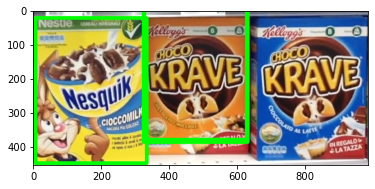

Product 0 - 1 instance/s found:
	Instance  position: (7, 20), width: 325px, height: 444px
Product 1 - 1 instance/s found:
	Instance  position: (327, -8), width: 294px, height: 390px
Product 11 - 1 instance/s found:
	Instance  position: (325, -7), width: 295px, height: 399px
Product 19 - 0 instance/s found:
Product 24 - 0 instance/s found:
Product 26 - 0 instance/s found:
Product 25 - 0 instance/s found:


Product 0 - 1 instance/s found:
	Instance  position: (-5, 522), width: 326px, height: 445px
Product 1 - 1 instance/s found:
	Instance  position: (315, 494), width: 295px, height: 391px
Product 11 - 1 instance/s found:
	Instance  position: (312, 494), width: 299px, height: 397px
Product 19 - 0 instance/s found:
Product 24 - 0 instance/s found:
Product 26 - 1 instance/s found:
	Instance  position: (32, -52), width: 344px, height: 497px
Product 25 - 1 instance/s found:
	Instance  position: (404, -17), width: 303px, height: 570px


Product 0 - 0 instance/s found:
Product 1 - 0 instance/s found:
Product 11 - 0 instance/s found:
Product 19 - 1 instance/s found:
	Instance  position: (359, -4), width: 294px, height: 387px
Product 24 - 0 instance/s found:
Product 26 - 0 instance/s found:
Product 25 - 1 instance/s found:
	Instance  position: (16, 3), width: 295px, height: 599px


In [24]:
for j in scenes_to_test:
    plt.imshow(cv2.cvtColor(e_scenes_images_features[j][IMAGE_INDEX], cv2.COLOR_BGR2RGB))
    plt.show()
    print_result(e_results, j)

#  Step B - Multiple Object Detection


 Computation of the center belonging to the model image.
 Knowing the model image has a rectangular shape, the center coordinates of the cereal box can be taken by halfing the vertical and horizontal dimensions of the model image; So definig a reference system with origin the top-left corner of the model image considering the vertical direction represented by the x-axis and the horizontal one represented by the y-axis then the center G of each model will be found in the position (height/2, width/2).
 

In [ ]:
#Definition of the function which find the model center and stores it in the dictionary "model_images_features"
def InstanceCenter(model_img,model_images_features, i, CENTER_INDEX=3):
    height, width, channels = model_img.shape
    v = int(height/2) # vertical coordinate of the image center
    h = int(width/2)  # horizontal position of the image center
    G = np.array([h, v]) # Defnition of the position center of the model
    if len( model_images_features[i])<=CENTER_INDEX:
        model_images_features[i].append(G) # Updating the model feature dictionary appending the information of the center
    else :
        #in the case G is already present in the model feature dictionary then update the G alreary there
        model_images_features[i][CENTER_INDEX] = G

Definition of the dictionary containing the informations of the scenes selected for this section:

In [ ]:
scenes_to_test = [1, 2, 3, 4, 5]

# Dictionary that contains the image, all keypoints and descriptors for each easy scene image
m_scenes_images_features = {}

for i in scenes_to_test:
    scene_img = cv2.imread('./scenes/m{}.png'.format(i), cv2.COLOR_BGR2RGB)
    kp_scene = sift.detect(scene_img)
    kp_scene, des_scene = sift.compute(scene_img, kp_scene)
    m_scenes_images_features[i] = [scene_img, kp_scene, des_scene]
    # scene_img_visualization = cv2.drawKeypoints(scene_img,kp_e_scemes_images['1'],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # plt.imshow(cv2.cvtColor(e_scenes_images_features[str(i)][0], cv2.COLOR_BGR2RGB))
    # plt.show()

Defining a function able to print out images that show up the location of the center and the position of each keypoints  :

In [ ]:
#Function defined to print the image where it is specified the location of the keypoints and the center of the image 
def Print_Center_Keypoint(model_img, model_images_features, GoodMatches,Img_scale=1000):
    #Print the G point in a resized version of each model image
    #creating a resized image of the model image in order to print the results in an homogeneous way
            #getting image dimensions 
    height, width, channels = model_img.shape
            #defining the new dimensions of the image
    dim_ratio = width/height
    new_height = Img_scale
    new_width  = int(new_height*dim_ratio)
    new_dim = (new_width, new_height)
            #image resizing
    resized_img = cv2.resize(model_img, new_dim, interpolation = cv2.INTER_AREA) 
            #computing the ratio between the vertical and the horizontal dimensions resizing process
    height_ratio = new_height/height
    width_ratio = new_width/width
            #computing the G in the image resized
    g_x = int(model_images_features[i][CENTER_INDEX][0]*width_ratio)
    g_y = int(model_images_features[i][CENTER_INDEX][1]*height_ratio)

            #computing the Kp points in the image resized
    for m in GoodMatches:
                # getting the coordinates of the m-th keypoint in the i-th model
        Kp_x = int(model_images_features[i][KEYPOINT_INDEX][m.queryIdx].pt[0])
        Kp_y = int(model_images_features[i][KEYPOINT_INDEX][m.queryIdx].pt[1])
        kp_x = int(Kp_x*width_ratio)
        kp_y = int(Kp_y*height_ratio)
                #Draw a Line 
        cv2.line(resized_img,(g_x,g_y),(kp_x,kp_y),(0,0,0),10) 
                #Drawing a dot in the position of Kp
        cv2.circle(resized_img,(kp_x, kp_y), 10, (0,255,0),20)
            
        #Drawing a dot in the position of G
    cv2.circle(resized_img,(g_x, g_y), 10, (255,55,236),25)
        #Plotting the resized image
    plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
    plt.show()    
    print("Number of Key point found : ",len(GoodMatches))    

Computing now the vectors starting from the keypoitns of the model and pointing the center G of the image then we would be able to identify the distance and the directions of each keypoint position with respect to G.

In [ ]:
# This function create or update the model_images_features dictionary which contains all the relevant features of the 
# each model image, with a list containing all the voting vectors computed for each good match between the keypoints of 
# the model and the scene image


def VotingVectors(Good_Matches,model_images_features):
    # getting the coordinates of the center of the i-th model, G
    G_x = model_images_features[i][CENTER_INDEX][0]
    G_y = model_images_features[i][CENTER_INDEX][1]
        
    #Initializing the vector V 
    V = []
    
    for m in Good_Matches:
        # getting the coordinates of the m-th keypoint in the i-th model
        Kp_x = int(model_images_features[i][KEYPOINT_INDEX][m.queryIdx].pt[0])
        Kp_y = int(model_images_features[i][KEYPOINT_INDEX][m.queryIdx].pt[1])
            
        #defining the point V = Kp[m,i] - G[i] 
        vx = Kp_x - G_x
        vy = Kp_y - G_y
            
        #computing the slope of the direction aligning the center point G with the m-th keypoint
        #in the case V = (0,0) it means basically that the point G[i] and Kp[m,i] are coincident and so the slope will not exist;
        # Or anothe case where the slope does not exist is if the the G[i] and the Kp[m,i] are aligned in a vertical line;
        #In such a cases the slope variable can be considered as an array containing two informations, the fisrt information is the 
        #actual value of the slope, while the second information encloses if the slope exists or not (1,0 respectively)
        if (np.abs(vx) + np.abs(vy)) == 0 :
            slope = [0, 0]
        elif vy == 0 :
            slope = [1, 0]
        else:
            slope = [vx/vy, 1]
            
        #creating an array containing the V coordinates and the slope of the line 
        v = [vx, vy, slope]
        V.append(v)

    if len( model_images_features[i]) <= V_INDEX :
        # Updating the model feature dictionary appending the information of the vector V
        model_images_features[i].append(V) 
    else: 
        #in the case V is already present in the model feature dictionary then update the V alreary there
        model_images_features[i][V_INDEX] = V

    return V    

In [ ]:
IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2
CENTER_INDEX     = 3
V_INDEX          = 4

for j in scenes_to_test:
    for i in range(NUM_OF_MODELS):
        
        model_img = cv2.imread('./models/{}.jpg'.format(i), cv2.COLOR_BGR2RGB)
        
        #Find or update the center of the model image information collected in the model features dictionary
        InstanceCenter(model_img,model_images_features, i, CENTER_INDEX=3) 
        
        #Finding matches between the keypoints of the scene and the keypoints found in the model
        good = Matching(model_images_features[i][DESCRIPTOR_INDEX], m_scenes_images_features[j][DESCRIPTOR_INDEX])
                
        # Creating or Updating the model feature dictionary with the informations regarding the voting vectors
        V = VotingVectors(good,model_images_features)
        
        # Print the model images
        Print_Center_Keypoint(model_img, model_images_features, good,Img_scale=1000)

            
            

Building now an accumulator array in order to estimate the position of the center of each instance of the model in the scene :

In [ ]:
#function which is supposed to take a scene image and, provided the dimension of a cell of the accumulator array, 
#it sections graphically the image in order to visualize the accumulator array referred to the scene

def plot_Img_sectioned(img, k1, k2):
    H,W = img.shape[:2]
    for w in range(0,W,k1):
        #Draw a Vertical Line 
        cv2.line(img,(w,0),(w,H),(0,0,0),3) 
    for h in range(0,H,k2):
        #Draw an Horizontal Line 
        cv2.line(img,(0,h),(W,h),(0,0,0),3) 
        
    #Plotting the tabled image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()   

In [ ]:
def KeyPoints_Comparison(models_images_features,scenes_images_features, Good_Matches):
    model_kps_size = [] #list containing the size of each matched keypoint belonging to the model
    scene_kps_size = [] #list containing the size of each matched keypoint belonging to the scene
    ratio_of_sizes = [] #list containing the ratio between the sizes of the same keypoint found in the model and in the scene, representing the change in dimensions
    
    model_kps_angle = [] #list containing the angle of each matched keypoint belonging to the model
    scene_kps_angle = [] #list containing the angle of each matched keypoint belonging to the scene
    relative_angles = [] #list containing the angle between the model and the scene, representing rotation occuring between model and scene instance
    
    for o in Good_Matches:
             #Defining two vectors respectively containing the size of the keypoints belonging to the model and 
             #to the scene
        M_kp_size = np.float32(models_images_features[i][KEYPOINT_INDEX][o.queryIdx].size)
        S_kp_size = np.float32(scenes_images_features[j][KEYPOINT_INDEX][o.trainIdx].size)
        model_kps_size.append(M_kp_size)
        scene_kps_size.append(S_kp_size)
             #Defining two vectors respectively containing the angle of the keypoints belonging to the model and 
             #to the scene        
        M_kp_angle = np.float32(models_images_features[i][KEYPOINT_INDEX][o.queryIdx].angle)
        S_kp_angle = np.float32(scenes_images_features[j][KEYPOINT_INDEX][o.trainIdx].angle)
        model_kps_angle.append(M_kp_angle)
        scene_kps_angle.append(S_kp_angle)

             #defining the change in dimensions between the keypoints of the model compared to the same ones found 
             #in the scene side
        ratio_of_sizes.append(M_kp_size/S_kp_size)
        
             #defining the change in dimensions between the keypoints of the model compared to the same ones found 
             #in the scene side
        relative_angles.append(M_kp_angle-S_kp_angle)       

    #computation of the mean scale factor
    if len(ratio_of_sizes) : 
        Mean_Scale_Factor = (sum(ratio_of_sizes))/len(ratio_of_sizes)
    else: 
        Mean_Scale_Factor = 0
    #computation of the mean relative angle
    if len(relative_angles) :
        Mean_Relative_Angle = (sum(relative_angles))/len(relative_angles)
    else: 
        Mean_Relative_Angle = 0
        
        
    return Mean_Scale_Factor, Mean_Relative_Angle

In [ ]:
def Accumulator_Array(ACC_ARRAY_CELL_DIMENSION_1, ACC_ARRAY_CELL_DIMENSION_2, Scene_img, Model_img, models_images_features, scenes_images_features, Good_Matches,V, i, j, KEYPOINT_INDEX = 1):
    #Accumulator dimensions
    Acc_dim = (int(scenes_images_features[j][0].shape[0] / ACC_ARRAY_CELL_DIMENSION_2), 
               int(scenes_images_features[j][0].shape[1] / ACC_ARRAY_CELL_DIMENSION_1))
    Accumulator_Array_Points = {}
    #Accumulator array as a matrix of zeroes
    Accumulator_Array = np.zeros(Acc_dim)
    #print(Accumulator_Array.shape)
    #extracting all the keypoints of the scene resulting in good matches
    scene_pts = np.float32([scenes_images_features[j][KEYPOINT_INDEX][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    #computing the mean scale factor and the mean relative angle occuring between the model and its instances on the scene
    r , alpha = KeyPoints_Comparison(models_images_features, scenes_images_features, Good_Matches)
    
    #defining the list wich will contain all the G estimation
    G_scene = []
    for l in range(len(Good_Matches)):
        # print((models_images_features[i][KEYPOINT_INDEX][Good_Matches[l].queryIdx].pt))
        #rescaling of the voting vectors
        Vx_scene = V[l][0] / r
        Vy_scene = V[l][1] / r
        #computing the estimate position of the center pointed by the l-th voting vector rescaled starting from the l-th keypoint
        Gx_scene = scene_pts[l][0][0] - Vx_scene
        Gy_scene = scene_pts[l][0][1] - Vy_scene

        #collecting the Center estimation in a list 
        G_scene.append([Gx_scene, Gy_scene])
        
        
        GS_x = int(Gx_scene/(ACC_ARRAY_CELL_DIMENSION_1))
        GS_y = int(Gy_scene/(ACC_ARRAY_CELL_DIMENSION_2))
        # print([Gx_scene, Gy_scene])
        if GS_x in range(Acc_dim[1]):
            if GS_y in range(Acc_dim[0]):
                # print([GS_y, GS_x])
                Accumulator_Array[GS_y,GS_x] += 1

                # save the scene points that fall into the current cell of the accumulator array, 
                if not (GS_y,GS_x, 'S') in Accumulator_Array_Points:
                    Accumulator_Array_Points[(GS_y, GS_x, 'S')] = []
                    Accumulator_Array_Points[(GS_y, GS_x, 'S')].append((Gx_scene, Gy_scene))
                else:
                    Accumulator_Array_Points[(GS_y, GS_x, 'S')].append((Gx_scene, Gy_scene))
                
                # save the model points corresponding to the scene point that fell into the current
                # cell of the accumulator array, so to be able to compute then the homography
                if not (GS_y,GS_x, 'M') in Accumulator_Array_Points:
                    Accumulator_Array_Points[(GS_y, GS_x, 'M')] = []
                    Accumulator_Array_Points[(GS_y, GS_x, 'M')].append(np.float32(models_images_features[i][KEYPOINT_INDEX][Good_Matches[l].queryIdx].pt))
                else:
                    Accumulator_Array_Points[(GS_y, GS_x, 'M')].append(np.float32(models_images_features[i][KEYPOINT_INDEX][Good_Matches[l].queryIdx].pt))

                # save also the list of indexes of good matches to use to be able to draw the bounding box later
                if not (GS_y,GS_x, 'L') in Accumulator_Array_Points:
                    Accumulator_Array_Points[(GS_y, GS_x, 'L')] = []
                    Accumulator_Array_Points[(GS_y, GS_x, 'L')].append(l)
                else:
                    Accumulator_Array_Points[(GS_y, GS_x, 'L')].append(l)
        
    #print(Accumulator_Array)
    
    return Accumulator_Array, G_scene, Accumulator_Array_Points

In [ ]:
'''
# Find index of maximum value from 2D numpy array
        result = np.where(ACC == np.amax(ACC))
        print('Max in Accumulator Array : ', np.amax(ACC))
        print('Tuple of arrays returned : ', result)
        listOfCoordinates = []
        for t in range(ACC.shape[0]):
            for w in range(ACC.shape[1]):
                if ACC[t,w]==np.amax(ACC):
                    listOfCoordinates.append([t,w])
            
        print('Number of maxima : ',len(listOfCoordinates))
        print('coord maxima : ',listOfCoordinates)
        cv2.rectangle(scene_img,(listOfCoordinates[0][0]*k,listOfCoordinates[0][1]*k),((listOfCoordinates[0][0]+1)*k,(listOfCoordinates[0][1]+1)*k),(0,255,0),10)
               #Plotting the tabled image
        plt.imshow(cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGB))
        plt.show() 
'''

In [ ]:
IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2

models_to_test = [0, 1, 11, 19, 24, 25, 26]


#dimension of a single cell of the accumulator array
ACC_ARRAY_CELL_DIMENSION_1 = 100
ACC_ARRAY_CELL_DIMENSION_2 = 120


# Parameters to tune
# minimum number of votes to consider G as a valid point
MIN_VOTES = 20
#treshold passed to the Matching function
MATCHING_TRESHOLD = 0.45



#print(m_scenes_images_features[1][0].shape[:2])
#plt.imshow(cv2.cvtColor(m_scenes_images_features[1][0], cv2.COLOR_BGR2RGB))
#plt.show()   
for j in scenes_to_test:
    scene_img = cv2.imread('./scenes/m{}.png'.format(j), cv2.COLOR_BGR2RGB)
    
    #for i in range(1):
    i = 0
    model_img = cv2.imread('./models/{}.jpg'.format(i), cv2.COLOR_BGR2RGB)

    #Finding matches between the keypoints of the scene and the keypoints found in the model
    good = Matching(model_images_features[i][DESCRIPTOR_INDEX], m_scenes_images_features[j][DESCRIPTOR_INDEX], 
                    Treshold=MATCHING_TRESHOLD)
    

    V = VotingVectors(good,model_images_features)

    ACC, G_scene, Accumulator_Array_Points = Accumulator_Array(ACC_ARRAY_CELL_DIMENSION_1,
                                                                  ACC_ARRAY_CELL_DIMENSION_2,
                                                                  scene_img, 
                                                                  model_img,
                                                                  model_images_features, 
                                                                  m_scenes_images_features, 
                                                                  good, 
                                                                  V, 
                                                                  i, j)
    for g in G_scene :
        #Drawing a dot in the position of G
        #print(g)
        #if np.max(ACC)>=20:
        cv2.circle(scene_img,(int(g[0]), int(g[1])), 10, (255,55,236),25)


    # Find index of maximum value from 2D numpy array
    listOfCoordinates = []
    print('List of highlighted cells:')
    # print(ACC.shape[0], ACC.shape[1])
    for t in range(ACC.shape[0]):
        for w in range(ACC.shape[1]):
            #print(t,w)
            # If a cell of the accumulator array has more than MIN_VOTES than it means that the model has been found
            if ACC[t,w] >= MIN_VOTES:
                print('  - Num votes: {} in cell {} '.format(ACC[t,w], (t,w)))
                # print('Max in Accumulator Array : ', np.max(ACC))
                listOfCoordinates.append([w, t])
                #print(Accumulator_Array_Points[(t, w, 'S')])
                
                # Plotting the bounding box
                M, mask = cv2.findHomography(np.float32(Accumulator_Array_Points[(t, w, 'M')]).reshape(-1,1,2), 
                                             np.float32(Accumulator_Array_Points[(t, w, 'S')]).reshape(-1,1,2)
                                             , cv2.RANSAC, 5.0)
                
                
                # Mask of discarded point used in visualization
                matchesMask = mask.ravel().tolist()

                # Corners of the query image
                height, width = model_images_features[i][IMAGE_INDEX].shape[:2]
                pts = np.float32([ [0,0],[0,height-1],[width-1,height-1],[width-1,0] ]).reshape(-1,1,2) # myc: these are the 4 corners of the query image

                # Projecting the corners into the train image
                dst = cv2.perspectiveTransform(pts, M) # myc: you project the corners by using the homography. M is the homography

                # Drawing the bounding box
                #scene_img = cv2.polylines(m_scenes_images_features[j][IMAGE_INDEX], [np.int32(dst)],
                 #                         True, (0, 255, 0), 3, cv2.LINE_AA)
                
                top_left_bound_box_corner = dst[0][0]
                bottom_left_bound_box_corner = dst[1][0]
                top_right_bound_box_corner = dst[3][0]
                bottom_right_bound_box_corner = dst[2][0]
                # print(top_left_bound_box_corner)

                scene_img = cv2.rectangle(m_scenes_images_features[j][IMAGE_INDEX],
                                          (int(top_left_bound_box_corner[0]), int(top_left_bound_box_corner[1])), 
                                          (int(bottom_right_bound_box_corner[0]), int(bottom_right_bound_box_corner[1])),
                                          (0,255,0),10)
            

                # Drawing the matches
                draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                                   singlePointColor = None, # not draw keypoints only matching lines
                                   matchesMask = matchesMask, # draw only inliers
                                   flags = 2) # not draw keypoints only lines
                
                new_good = []
                for index in Accumulator_Array_Points[(t, w, 'L')]:
                    new_good.append(good[index])
                
                img3 = cv2.drawMatches(model_images_features[i][IMAGE_INDEX], 
                                       model_images_features[i][KEYPOINT_INDEX], 
                                       m_scenes_images_features[j][IMAGE_INDEX], 
                                       m_scenes_images_features[j][KEYPOINT_INDEX],
                                       new_good, 
                                       None,  
                                       **draw_params)
                plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
                plt.show()
                
    
    
    print(listOfCoordinates)
    
    
    for c in listOfCoordinates :
        cv2.rectangle(scene_img,(c[0]*ACC_ARRAY_CELL_DIMENSION_1,c[1]*ACC_ARRAY_CELL_DIMENSION_2),
                      ((c[0]+1)*ACC_ARRAY_CELL_DIMENSION_1,(c[1]+1)*ACC_ARRAY_CELL_DIMENSION_2),(0,255,0),10)

    
    #plotting the scene image
    plt.imshow(cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGB))
    plt.show()        
 
    
    plot_Img_sectioned(scene_img, ACC_ARRAY_CELL_DIMENSION_1, ACC_ARRAY_CELL_DIMENSION_2)
    print(ACC[ACC != 0])
    
